In [124]:
import numpy as np
import pandas as pd
import root_pandas
import root_numpy

import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

from itertools import islice

from tqdm import tqdm

import ROOT

In [66]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 7)

# Read in Data from `/net/storage`

In [93]:
filename = '/net/lhcb-tank/user_area/kheinicke/flavourtagging/Bu2JpsiK_2012_MD_TrainingTuple-OSE-OSK-OSMu_sweighted_kheinick.root'
chunksize = 1000

In [94]:
DATA = root_pandas.read_root(filename,
                             key='DecayTree',
                             columns=['B_OS_Muon*', 'B_*'],
                             ignore=['B_ENDVERTEX_COV_',
                                     'B_OWNPV_COV_',
                                     'B_TOPPV_COV_',
                                     'B_OS_E*',
                                     'B_OS_K*',
                                     'B_All*',
                                     'B_Hlt*',
                                     'B_L0*',
                                    ],
                             chunksize=chunksize,
                             where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',
                             flatten=True
                            )

In [95]:
# ok... this is overkill but naaa
f = ROOT.TFile(filename)
t = f.Get('DecayTree')
n_entries = t.GetEntries()

In [96]:
full_data = pd.DataFrame()

# df_DATA = DATA
for df_DATA in tqdm(DATA, total=n_entries/chunksize):
    # only muons
    df_DATA = df_DATA[df_DATA.B_OS_Muon_ABSID==13]

    # Add datas target
    # The tag decision is defined by the tagger muons charge. The mistag estimates target will therefore be, wheter the sign of the tagging particle is equal to the signal candidates sign.

    df_DATA['target'] = (np.sign(df_DATA.B_ID) == (np.sign(df_DATA.B_OS_Muon_ID)))

    # should be "really" unique (event number/key )
    gb = df_DATA.groupby('B_P')

    # select tagging particle with maximum pt
    max_pt_DATA = df_DATA.loc[gb['B_OS_Muon_PT'].agg(np.argmax).astype('int')]
    
    full_data = full_data.append(max_pt_DATA)

  0%|          | 0/406.581 [00:00<?, ?it/s]/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
407it [09:45,  1.40s/it]                             


In [128]:
classic_MVA_features = [
    'B_OS_Muon_countTracks',  # aka mult
    'B_OS_Muon_P',
    'B_OS_Muon_PT',
    'B_PT',
#    'B_OS_Muon_ABS_RecVertexIP',  # aka IPs
    'B_OS_Muon_TRCHI2DOF',
    'B_OS_Muon_PROBNNmu',
    'B_OS_Muon_TRGHP',
#    'B_OS_Muon_IPPUs',
]

In [129]:
classic_data = full_data[classic_MVA_features]
labels = full_data.target

In [130]:
classic_data.describe()

,B_OS_Muon_countTracks,B_OS_Muon_P,B_OS_Muon_PT,B_PT,B_OS_Muon_TRCHI2DOF,B_OS_Muon_PROBNNmu,B_OS_Muon_TRGHP
count,406567.000000,406567.000000,406567.000000,406567.000000,406567.000000,406567.000000,406567.000000
mean,43.336754,44543.656250,3419.997070,5910.417293,1.117127,0.603364,0.042020
std,19.535456,34270.957031,1661.364868,4370.851246,0.406872,0.634797,0.092136
min,3.000000,2203.149902,106.138947,12.014025,0.207976,-1.000000,0.000000
25%,29.000000,19373.224609,2245.221191,2896.155811,0.842170,0.676960,0.007077
50%,41.000000,34237.468750,2920.594971,4872.650065,1.043222,0.876867,0.013229
75%,55.000000,58737.835938,4079.892456,7695.108291,1.297725,0.947034,0.026588
max,203.000000,199980.703125,9999.018555,73716.693317,2.999745,0.999994,0.499997


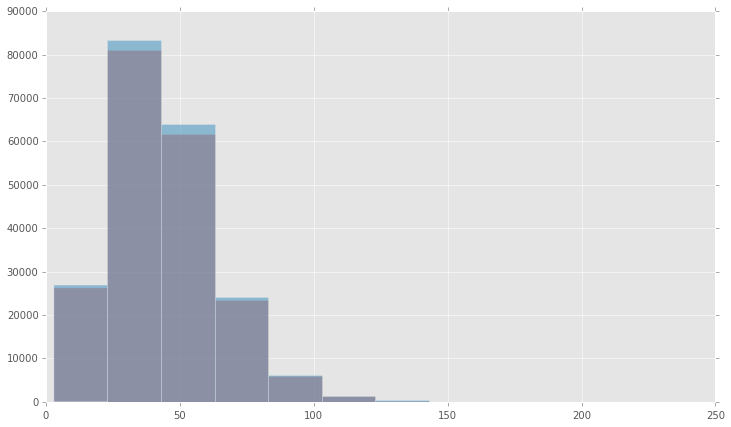

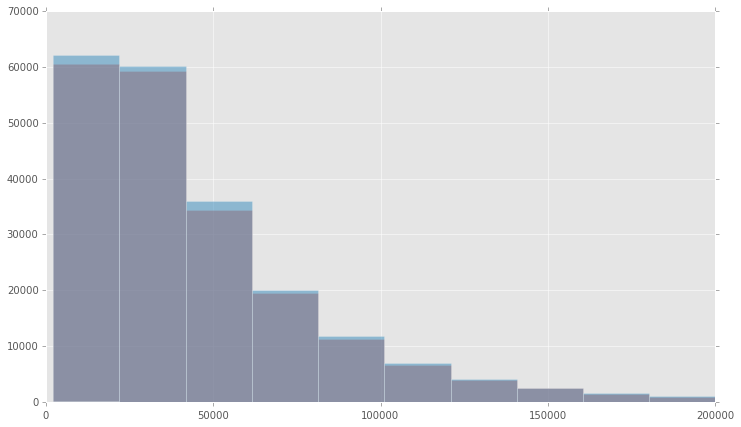

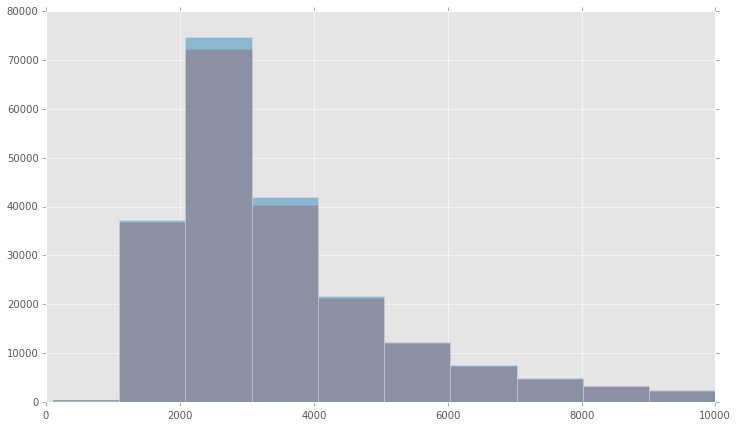

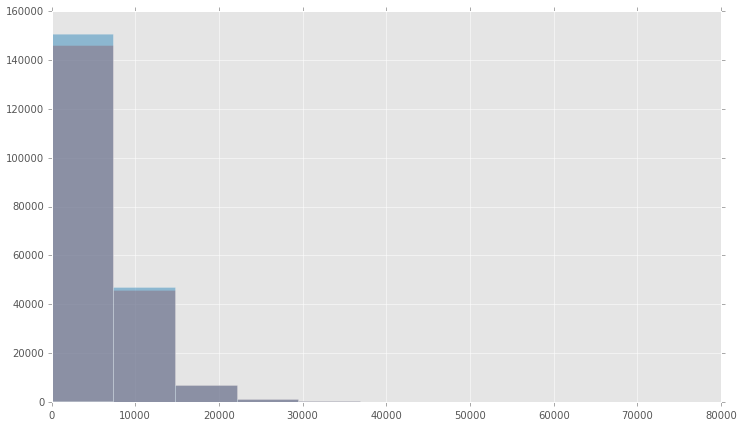

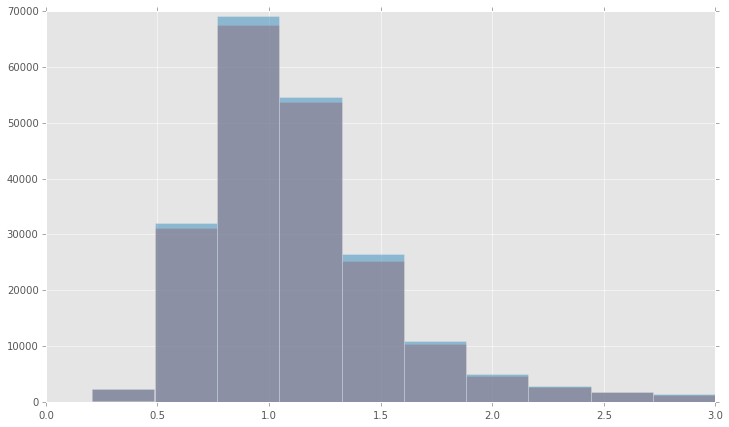

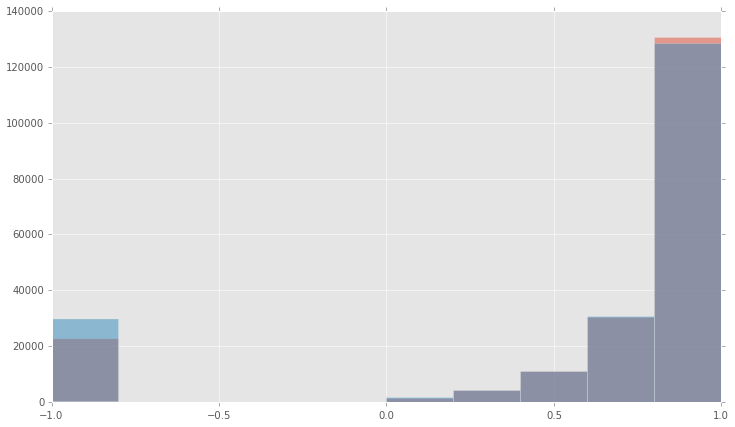

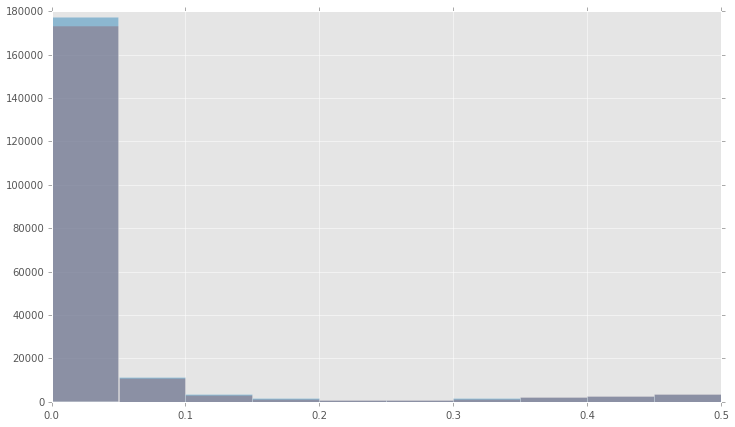

In [144]:
for f in classic_data.columns:
    _, bins = np.histogram(classic_data[f])
    classic_data[labels==True][f].hist(bins=bins, alpha=0.5)
    classic_data[labels==False][f].hist(bins=bins, alpha=0.5)
    plt.show()

In [131]:
train_data, test_data, train_labels, test_labels = train_test_split(classic_data, labels, test_size=0.3)

In [132]:
gbm = xgb.XGBClassifier(max_depth=6, silent=False)

In [133]:
gbm.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [140]:
probas = gbm.predict_proba(test_data)[:,1]
preds = gbm.predict(test_data)
score = roc_auc_score(test_labels, probas)

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(train_data, train_labels)

In [ ]:
gb_probas = gb.predict_proba(test_data)[:,1]
gb_score = roc_auc_score(test_labels, gb_probas)

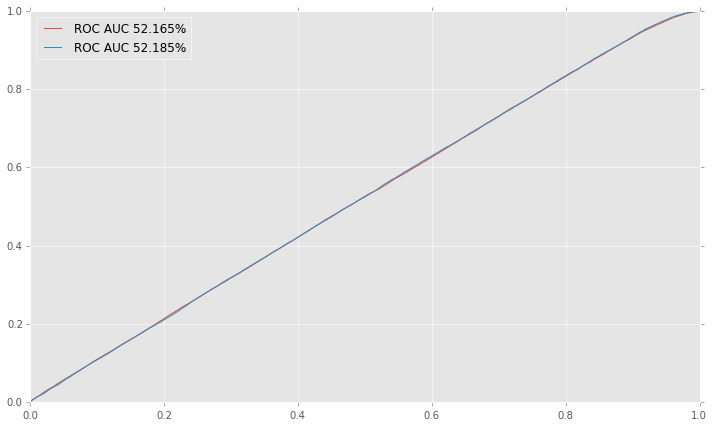

In [139]:
plt.plot(*roc_curve(test_labels, gb_probas)[:2], label='ROC AUC {:2.3f}%'.format(gb_score * 100))
plt.plot(*roc_curve(test_labels, probas)[:2], label='ROC AUC {:2.3f}%'.format(score * 100))
plt.legend(loc='best')
plt.show()